In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost

In [293]:
df = pd.read_csv("../data/raw/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID                                     955 non-null    object 
 1   Пол                                    954 non-null    object 
 2   Семья                                  955 non-null    object 
 3   Этнос                                  955 non-null    object 
 4   Национальность                         955 non-null    object 
 5   Религия                                955 non-null    object 
 6   Образование                            955 non-null    object 
 7   Профессия                              955 non-null    object 
 8   Вы работаете?                          955 non-null    int64  
 9   Выход на пенсию                        955 non-null    int64  
 10  Прекращение работы по болезни          955 non-null    int64  
 11  Сахарн

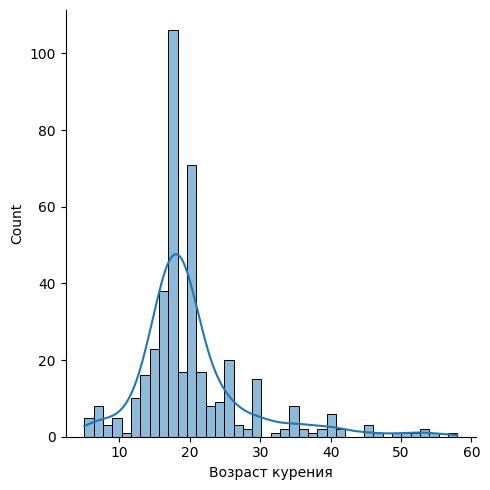

In [243]:
import seaborn as sns
sns.displot(df["Возраст курения"], kde=True) # Возможно кто-то из отвечаюих понял это как "Продолжительность курения"

Похоже, что возраст курения - возраст, в которм человек начал курить, а не сколько лет курит

In [294]:
nans = df.iloc[:, -5:].corrwith(df["Возраст курения"]).rename("NaNs")
mean = df.iloc[:, -5:].corrwith(df["Возраст курения"].fillna(df["Возраст курения"].mean())).rename("Mean")
zeroes = df.iloc[:, -5:].corrwith(df["Возраст курения"].fillna(0)).rename("Zeroes")
pd.concat([nans, mean, zeroes], axis=1)

,NaNs,Mean,Zeroes
Артериальная гипертензия,0.082508,0.053732,-0.036623
ОНМК,0.000861,0.000571,0.003147
"Стенокардия, ИБС, инфаркт миокарда",-0.007958,-0.005114,-0.016511
Сердечная недостаточность,0.075149,0.041313,-0.064340
Прочие заболевания сердца,0.092229,0.059759,0.020556


In [245]:

nans = df.iloc[:, -5:].corrwith(df["Возраст алког"]).rename("NaNs")
mean = df.iloc[:, -5:].corrwith(df["Возраст алког"].fillna(df["Возраст алког"].mean())).rename("Mean")
zeroes = df.iloc[:, -5:].corrwith(df["Возраст алког"].fillna(0)).rename("Zeroes")
pd.concat([nans, mean, zeroes], axis=1)

,NaNs,Mean,Zeroes
Артериальная гипертензия,0.101612,0.092137,0.006058
ОНМК,0.018077,0.017136,0.045679
"Стенокардия, ИБС, инфаркт миокарда",0.034184,0.030837,0.005183
Сердечная недостаточность,0.076321,0.066845,-0.013339
Прочие заболевания сердца,0.016368,0.014388,-0.033091


Замена на `mean` даёт более близкие к изначальному распределению корреляции, поэтому стоит использовать их?

In [295]:
import cmath


def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.set_index("ID")
    df["Пол"] = df["Пол"].fillna(df["Пол"].mode()[0])
    df = df.drop("ID_y", axis=1)
    df = process_smoking(df)
    df = process_passive_smoking(df)
    df = process_sleeping(df)
    df = process_alcho(df)
    return df


def process_alcho(df: pd.DataFrame) -> pd.DataFrame:
    rating_map = {
        "никогда не употреблял": 0.0,
        "ранее употреблял": 0.5,
        "употребляю в настоящее время": 1.0,
    }
    df["Алкоголь"] = df["Алкоголь"].map(rating_map)
    df["Возраст алког"] = df["Возраст алког"].fillna(df["Возраст алког"].mean())

    return df


def process_smoking(df: pd.DataFrame) -> pd.DataFrame:
    rating_map = {
        "Никогда не курил(а)": 0.0,
        "Бросил(а)": 0.5,
        "Курит": 1.0,
    }
    df["Статус Курения"] = df["Статус Курения"].map(rating_map)
    df["Возраст курения"] = df["Возраст курения"].fillna(df["Возраст курения"].mean())

    mean_cigs = df["Сигарет в день"].mean()

    def replace_cigs_num(row):
        if not cmath.isnan(row["Сигарет в день"]):
            val = row["Сигарет в день"]
        elif row["Статус Курения"] == "Курит":
            val = mean_cigs
        elif row["Статус Курения"] == "Бросил(а)":
            val = mean_cigs * 0.5
        else:
            val = 0.0
        row["Сигарет в день"] = val
        return row

    df = df.apply(lambda row: replace_cigs_num(row), axis=1)
    return df


def process_passive_smoking(df: pd.DataFrame) -> pd.DataFrame:
    pass_smoking_map = {
        "1-2 раза в неделю": 1.0 / 5.0,
        "3-6 раз в неделю": 2.0 / 5.0,
        "не менее 1 раза в день": 3.0 / 5.0,
        "2-3 раза в день": 4.0 / 5.0,
        "4 и более раз в день": 5.0 / 5.0,
        pd.NA: pd.NA,
    }
    df["Частота пасс кур"] = df["Частота пасс кур"].map(pass_smoking_map)
    pass_smoking_mean = df["Частота пасс кур"].mean()

    def replace_pass_smoking(row):
        if not cmath.isnan(row["Частота пасс кур"]):
            val = row["Частота пасс кур"]
        elif row["Пассивное курение"] == 1:
            val = pass_smoking_mean
        else:
            val = 0.0
        row["Частота пасс кур"] = val
        return row

    df = df.apply(lambda row: replace_pass_smoking(row), axis=1)
    return df


def process_sleeping(df: pd.DataFrame) -> pd.DataFrame:
    def time_to_hours(x):
        h, s, m = map(int, x.split(":"))
        return h + m / 60 + s / 60 / 60

    start_times = df["Время засыпания"].map(time_to_hours)
    # Для расположения времени до полночи и после рядом
    df["Время засыпания"] = (start_times + 11) % 24
    end_times = df["Время пробуждения"].map(time_to_hours)
    df["Время пробуждения"] = end_times
    sleep_duration = ((end_times - start_times) % 24).rename("Продолжительность сна")
    df = pd.concat([df.iloc[:, :-5], sleep_duration, df.iloc[:, -5:]], axis=1)
    return df


In [296]:
df = preprocess(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 955 entries, 54-102-358-02 to 54-702-016-01
Data columns (total 38 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Пол                                    955 non-null    object 
 1   Семья                                  955 non-null    object 
 2   Этнос                                  955 non-null    object 
 3   Национальность                         955 non-null    object 
 4   Религия                                955 non-null    object 
 5   Образование                            955 non-null    object 
 6   Профессия                              955 non-null    object 
 7   Вы работаете?                          955 non-null    int64  
 8   Выход на пенсию                        955 non-null    int64  
 9   Прекращение работы по болезни          955 non-null    int64  
 10  Сахарный диабет                        955 non-null    in

In [297]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-5]
y = df.iloc[:, -5:]
# cat_features = set(X.columns)
# cat_features.difference_update(
#     {
#         "Переломы",
#         "Травмы за год",
#         "Возраст курения",
#         "Статус Курения",
#         "Сигарет в день",
#         "Возраст алког",
#         "Частота пасс кур",
#         "Продолжительность сна",
#         "Время пробуждения",
#         "Время засыпания",
#     }
# )
# cat_features = list(cat_features)
cat_features = list(X.columns[X.dtypes == "object"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [298]:
import catboost

# # MultiLabel is garbage...
# cb = catboost.CatBoostClassifier(
#     cat_features=cat_features,
#     loss_function="M",
#     custom_metric=["Recall"],
#     eval_metric="HammingLoss",
#     class_names=list(y_test.columns),
#     depth=4, rsm=1, random_strength=1, l2_leaf_reg=1, class_weights=[0.5, 0.5],
#     iterations=10000
# )
# cb.fit(X=X_train, y=y_train, eval_set=(X_test, y_test), plot=True)
cb= catboost.CatBoostClassifier(
    cat_features=cat_features,
    loss_function="Logloss",
    auto_class_weights="Balanced",
    depth=4,
    learning_rate=0.015,
)
cb.fit(X=X_train, y=y_train.iloc[:, 1], eval_set=(X_test, y_test.iloc[:, 1]), plot=True, use_best_model=True)

/usr/local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6918746	test: 0.6927693	best: 0.6927693 (0)	total: 10ms	remaining: 10s
1:	learn: 0.6913649	test: 0.6929352	best: 0.6927693 (0)	total: 18.9ms	remaining: 9.44s
2:	learn: 0.6882141	test: 0.6916985	best: 0.6916985 (2)	total: 29.4ms	remaining: 9.76s
3:	learn: 0.6845250	test: 0.6906148	best: 0.6906148 (3)	total: 37.7ms	remaining: 9.39s
4:	learn: 0.6807841	test: 0.6920015	best: 0.6906148 (3)	total: 47.8ms	remaining: 9.52s
5:	learn: 0.6804567	test: 0.6916324	best: 0.6906148 (3)	total: 54.8ms	remaining: 9.08s
6:	learn: 0.6795788	test: 0.6912325	best: 0.6906148 (3)	total: 59.9ms	remaining: 8.5s
7:	learn: 0.6769038	test: 0.6901844	best: 0.6901844 (7)	total: 64.7ms	remaining: 8.03s
8:	learn: 0.6754161	test: 0.6902231	best: 0.6901844 (7)	total: 68.7ms	remaining: 7.57s
9:	learn: 0.6732109	test: 0.6902387	best: 0.6901844 (7)	total: 76.7ms	remaining: 7.6s
10:	learn: 0.6728287	test: 0.6902781	best: 0.6901844 (7)	total: 80.2ms	remaining: 7.21s
11:	learn: 0.6716859	test: 0.6897111	best: 0.689

In [300]:
from sklearn.metrics import classification_report
print(classification_report(y_test.iloc[:, 1], cb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       180
           1       0.15      0.45      0.22        11

    accuracy                           0.82       191
   macro avg       0.55      0.65      0.56       191
weighted avg       0.91      0.82      0.86       191



/usr/local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [173]:
# from sklearn.metrics import classification_report
# for pred, real, name in zip(zip(*cb.predict(X_test)), zip(*y_test.values), y_test.columns):
#     print(name)
#     print(classification_report(real, pred))

/usr/local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


TypeError: 'numpy.int64' object is not iterable

/usr/local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.6892348	test: 0.6898737	best: 0.6898737 (0)	total: 2.15ms	remaining: 2.15s
750:	learn: 0.4070135	test: 0.5805187	best: 0.5748752 (571)	total: 1.88s	remaining: 622ms
999:	learn: 0.3642975	test: 0.5859741	best: 0.5748752 (571)	total: 2.46s	remaining: 0us

bestTest = 0.5748752496
bestIteration = 571

Shrink model to first 572 iterations.
recall:  0.7044905577514273


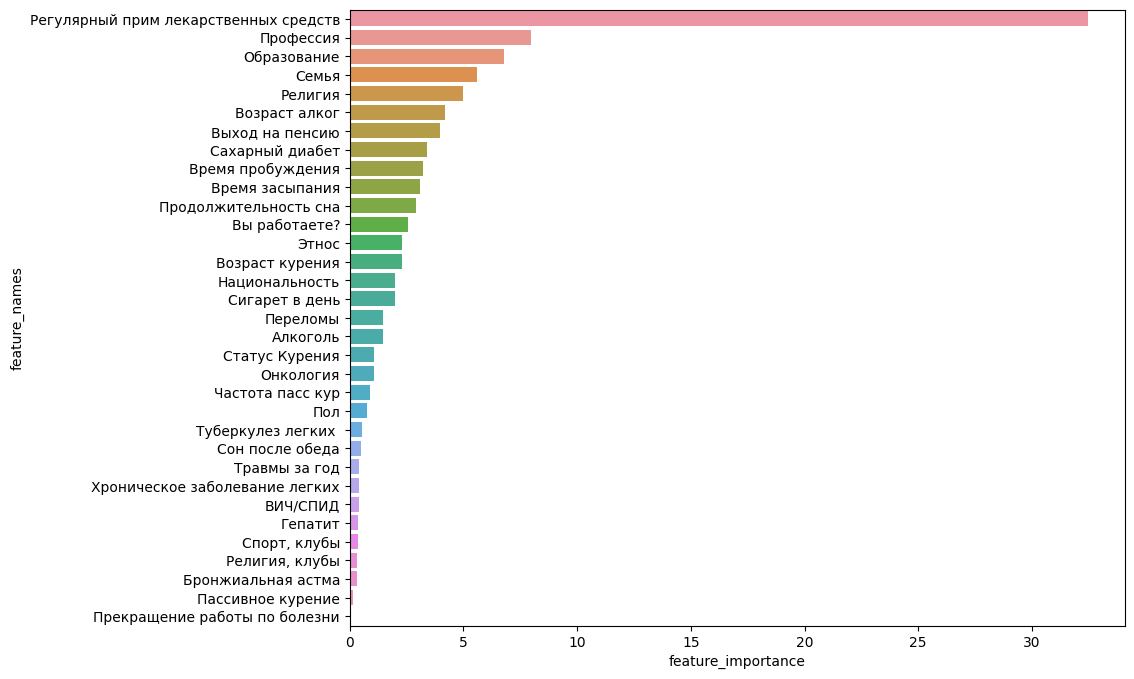

/usr/local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.6852885	test: 0.6920174	best: 0.6920174 (0)	total: 2.18ms	remaining: 2.18s
750:	learn: 0.0993070	test: 0.9995586	best: 0.6641289 (142)	total: 1.68s	remaining: 557ms
999:	learn: 0.0530854	test: 1.1579742	best: 0.6641289 (142)	total: 2.26s	remaining: 0us

bestTest = 0.6641289433
bestIteration = 142

Shrink model to first 143 iterations.
recall:  0.645959595959596


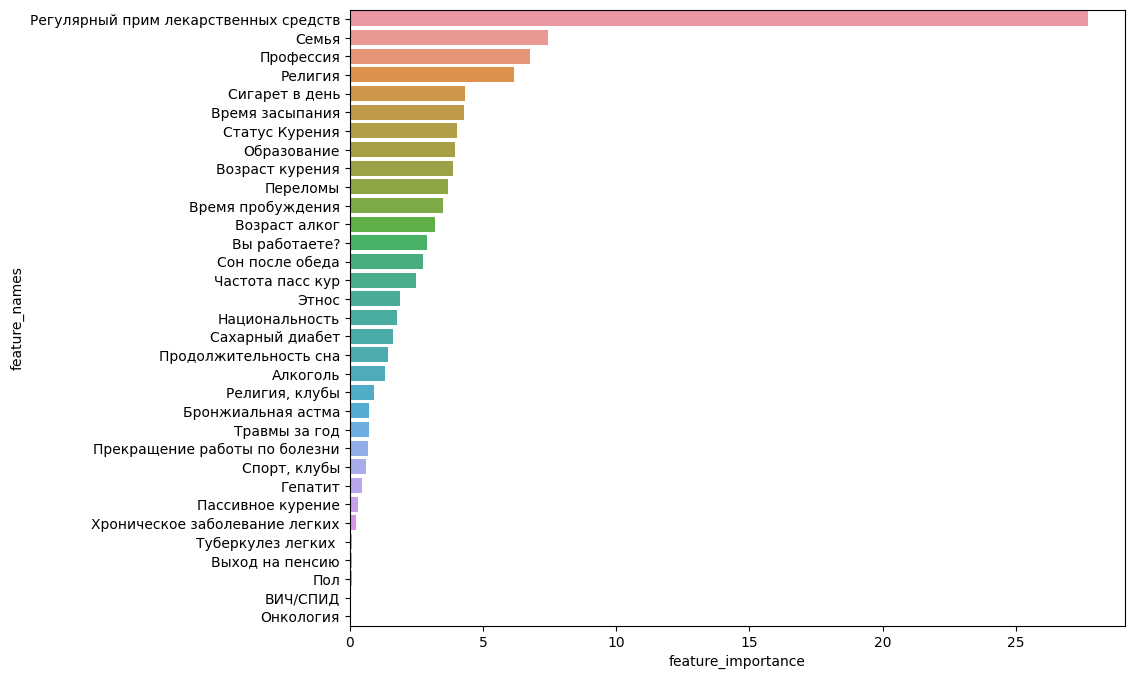

/usr/local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.6900969	test: 0.6907837	best: 0.6907837 (0)	total: 4.07ms	remaining: 4.07s
750:	learn: 0.2954535	test: 0.6951979	best: 0.6467287 (87)	total: 1.81s	remaining: 602ms
999:	learn: 0.2384349	test: 0.7349885	best: 0.6467287 (87)	total: 2.41s	remaining: 0us

bestTest = 0.6467287451
bestIteration = 87

Shrink model to first 88 iterations.
recall:  0.5754399585921326


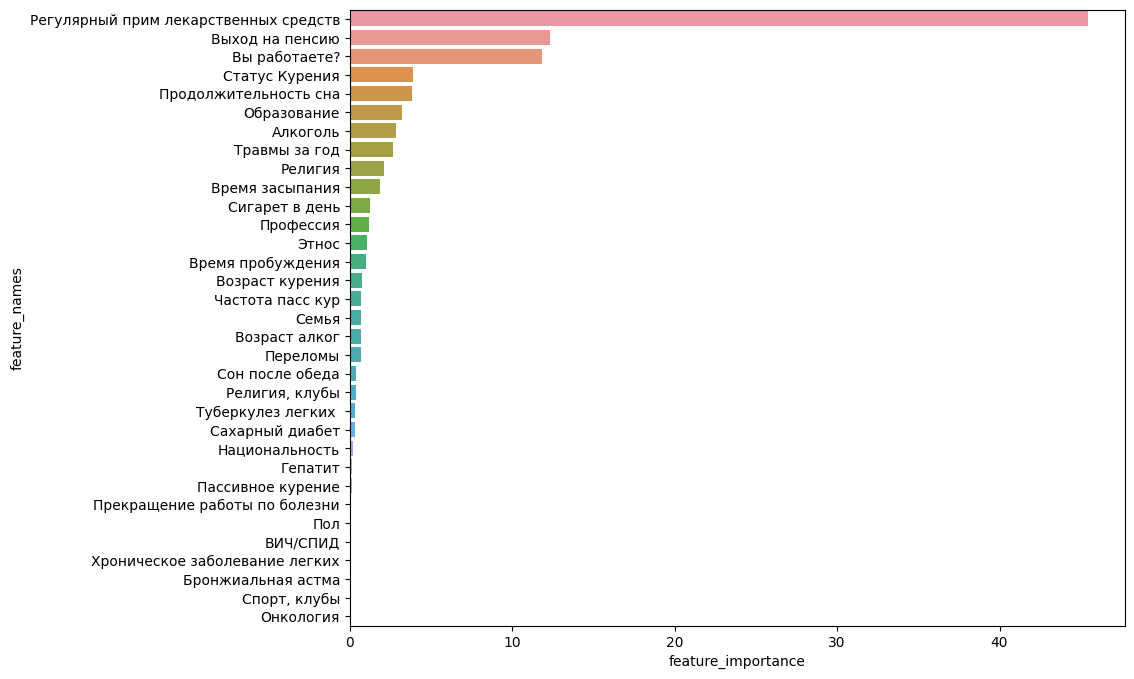

/usr/local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.6916378	test: 0.6912849	best: 0.6912849 (0)	total: 1.44ms	remaining: 1.44s
750:	learn: 0.2775540	test: 0.7716549	best: 0.6223451 (166)	total: 1.77s	remaining: 587ms
999:	learn: 0.2140650	test: 0.8560347	best: 0.6223451 (166)	total: 2.33s	remaining: 0us

bestTest = 0.6223451311
bestIteration = 166

Shrink model to first 167 iterations.
recall:  0.6832298136645962


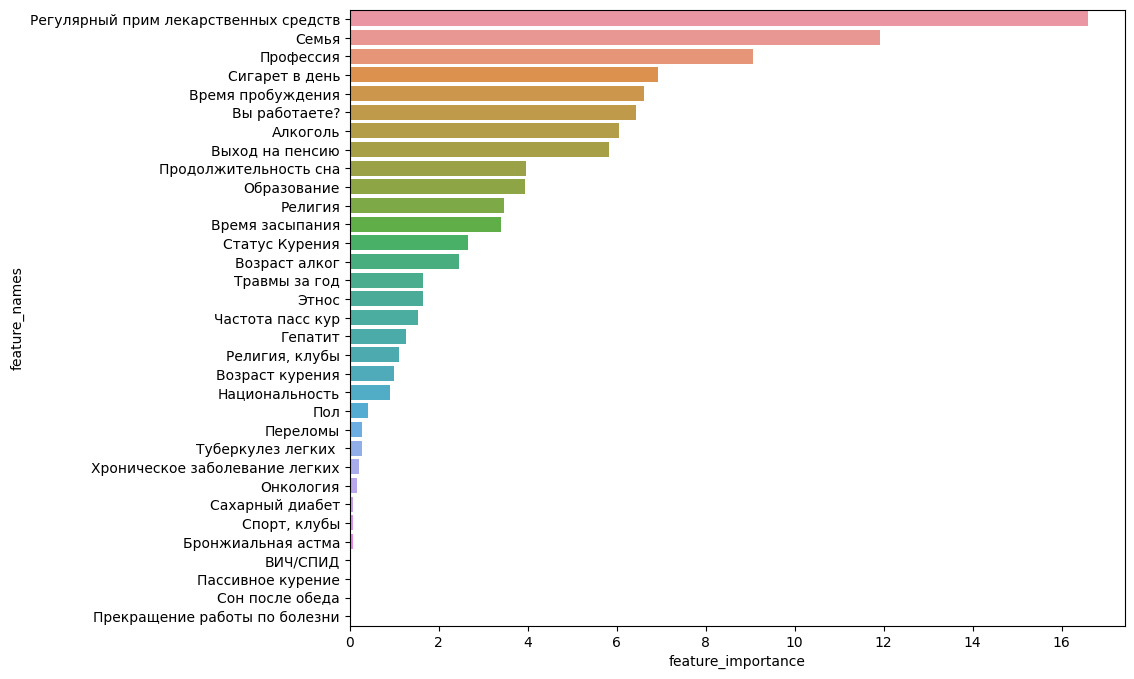

/usr/local/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.6927746	test: 0.6936748	best: 0.6936748 (0)	total: 1.37ms	remaining: 1.37s
750:	learn: 0.2618552	test: 1.0691039	best: 0.6925426 (5)	total: 1.8s	remaining: 597ms
999:	learn: 0.1902980	test: 1.3090535	best: 0.6925426 (5)	total: 2.39s	remaining: 0us

bestTest = 0.6925425524
bestIteration = 5

Shrink model to first 6 iterations.
recall:  0.5412048192771084


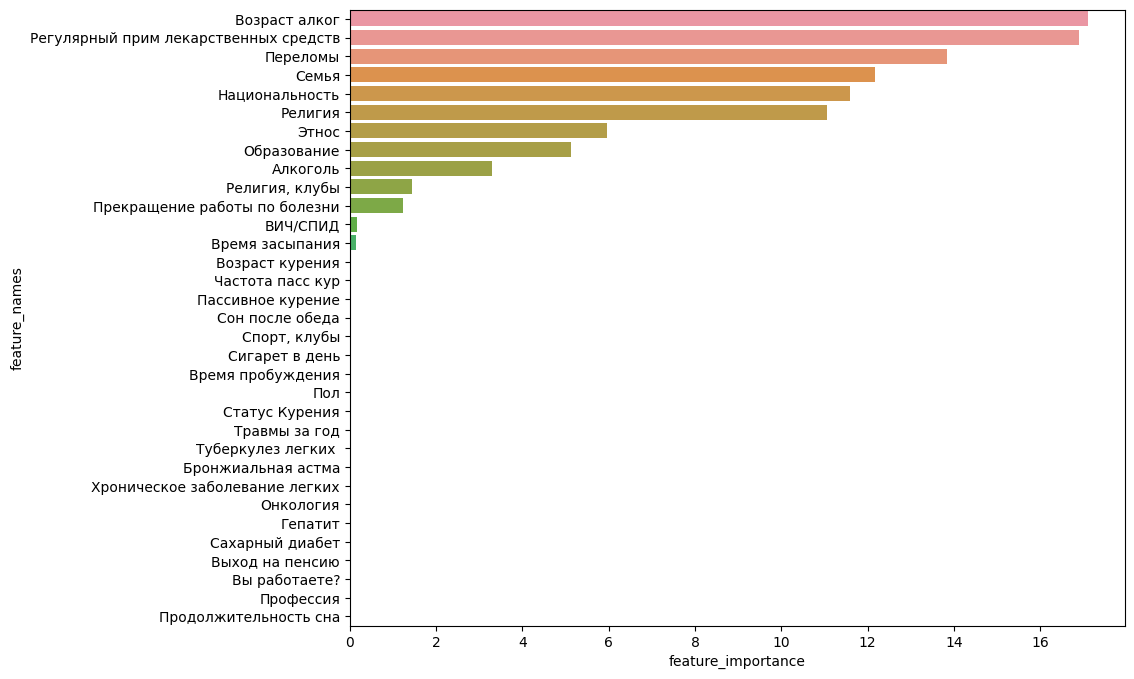

In [263]:
# Shamelessly stolen from Dmitri Sokolov's submission

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
import numpy as np

val_preds = []
val_probas = []
test_preds = []
test_probas = []
recall_all = []

def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.show()

for i in range(0,5):
    train_pool = catboost.Pool(X_train, y_train.iloc[:, i], cat_features=cat_features)
    val_pool = catboost.Pool(X_test, y_test.iloc[:, i], cat_features=cat_features)
    # test_pool = catboost.Pool(test, cat_features=cat_features)
    
    base_model = catboost.CatBoostClassifier(iterations=1000, random_seed=43, custom_metric=['Recall'], auto_class_weights='Balanced', \
                                   depth=4, rsm=1, random_strength=1, l2_leaf_reg=1, learning_rate=0.015)
    base_model.fit(train_pool, verbose=750, eval_set=val_pool, use_best_model=True) 
    
    val_pred = base_model.predict(val_pool)
    val_proba = base_model.predict_proba(val_pool)
    val_probas.append(val_proba)
    recall = recall_score(y_test.iloc[:, i].values, val_pred , average='macro')
    recall_all.append(recall)
    print('recall: ', recall)
    val_preds.append(val_pred)
    
    # test_pred = base_model.predict(test_pool)
    # test_proba = base_model.predict_proba(test_pool)
    # test_preds.append(test_pred)
    # test_probas.append(test_proba)
    
    plot_feature_importance(base_model.get_feature_importance(), X_train.columns)
    
    plt.show()

In [426]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

col_tr = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(), cat_features)  
])
col_tr.fit(X) # to fit all features

pipe = Pipeline(steps=[
    ("col_tr", col_tr),
    ("clf", SGDClassifier(
        verbose=0,
        random_state=1,
        class_weight="balanced",
        loss="log_loss",
        alpha=0.0001
        
    )),
])
X_train_tr = col_tr.transform(X_train)
skip_pipe = Pipeline(pipe.steps[-1:])
skip_pipe.fit(X_train_tr, y_train.iloc[:, 1])

print(classification_report(y_test.iloc[:, 1], pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.18      0.31       180
           1       0.07      1.00      0.13        11

    accuracy                           0.23       191
   macro avg       0.53      0.59      0.22       191
weighted avg       0.95      0.23      0.30       191



In [373]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__loss': ("modified_huber", "log_loss", "huber", "squared_hinge", "perceptron", "hinge"),
    'clf__penalty': ('l2', 'l1', 'elasticnet'),
    'clf__max_iter': (100, 1000, 10000),
    'clf__power_t': (0.1, 0.5, 0.9),
    'clf__learning_rate': ("constant", "optimal", "invscaling", "adaptive"),
    "clf__eta0": (0.0, 0.5, 1.0, 1.5),
    "clf__alpha": (0.00001, 0.0001, 0.001),
}

gs = GridSearchCV(skip_pipe, param_grid, verbose=0, cv=3)
gs.fit(X_train_tr, y_train.iloc[:, 1])
best = gs.best_estimator_
X_test_tr = col_tr.transform(X_test)
print(gs.best_params_)
print(classification_report(y_test.iloc[:, 1], best.predict(X_test_tr)))

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

{'clf__alpha': 0.0001, 'clf__early_stopping': False, 'clf__eta0': 1.5, 'clf__learning_rate': 'constant', 'clf__loss': 'huber', 'clf__max_iter': 100, 'clf__penalty': 'l1', 'clf__power_t': 0.1}
              precision    recall  f1-score   support

           0       1.00      0.07      0.12       180
           1       0.06      1.00      0.12        11

    accuracy                           0.12       191
   macro avg       0.53      0.53      0.12       191
weighted avg       0.95      0.12      0.12       191



/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.63486697 0.63486697 0.63486697]
  warnings.warn(
